# Calculating the integrated gradients from the CAE-VIB model:

**Importing necessary packages**

In [1]:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior() 
  assert tf2.enabled()

import numpy as np
import tensorflow as tf


from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Conv2D

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import math
import os

import matplotlib.pyplot as plt
import glob 

mode = 'train'   

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

import time
time1 = time.time()

Num GPUs: 1


**Defining data loading functions**

In [2]:
seed_value = 9
num_tot = 100
num_epochs = 200
nGrid= 128 
max_evals = 5 
dtype = 'non-rotated'


np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def shuffle(X, y):
    shuffleOrder = np.arange(X.shape[0])
    np.random.shuffle(shuffleOrder)
    X = X[shuffleOrder]
    y = y[shuffleOrder]
    return X, y, shuffleOrder

def load_data_TrainTestVal(n):
    os.chdir('./Results_2/')
    dirIn0 = '../data/Data_split-' + dtype + '/Data_split/'
    dirIn1 = 'Data_Split_N'+str(n)+'/'
    dirIn = dirIn0 + dirIn1
    print(dirIn)
    print(glob.glob(dirIn + 'input_train_data*'))
    train_data = np.load(glob.glob(dirIn + 'input_train_data*')[0])
    train_target = np.load(glob.glob(dirIn + 'output_train_data*')[0])
    test_data = np.load(glob.glob(dirIn + 'input_test_data*')[0])
    test_target = np.load(glob.glob(dirIn + 'output_test_data*')[0])
    valid_data = np.load(glob.glob(dirIn + 'input_val_data*')[0])
    valid_target = np.load(glob.glob(dirIn + 'output_val_data*')[0]) 
    return (train_data, train_target), (test_data, test_target), (valid_data, valid_target)


def load_data_prepared():
    (train_input, train_target), (test_input, test_target), (valid_input, valid_target) = load_data_TrainTestVal(num_tot)
    tmin = train_input.min()    
    tmax = train_input.max()
    train_images = (train_input - tmin) / (tmax - tmin) # Normalize the images to [-1, 1]
    test_images = (test_input - tmin) / (tmax - tmin)
    valid_images = (valid_input - tmin) / (tmax - tmin)
    shape0 = train_images.shape[0]
    swe_train_data = train_images.reshape(shape0, nGrid, nGrid, 1)
    shape0 = test_images.shape[0]
    swe_test_data = test_images.reshape(shape0, nGrid, nGrid, 1)   
    shape0 = valid_images.shape[0]
    swe_valid_data = valid_images.reshape(shape0, nGrid, nGrid, 1)        
    ############################################    
    tmin = train_target.min()    
    tmax = train_target.max()
    train_target = (train_target - tmin) / (tmax - tmin) # Normalize the images to [-1, 1]
    test_target = (test_target - tmin) / (tmax - tmin)
    valid_target = (valid_target - tmin) / (tmax - tmin)
    shape0 = train_target.shape[0]
    swe_train_target = train_target.reshape(shape0, nGrid, nGrid, 1)
    shape0 = test_target.shape[0]
    swe_test_target = test_target.reshape(shape0, nGrid, nGrid, 1)    
    shape0 = valid_target.shape[0]
    swe_valid_target = valid_target.reshape(shape0, nGrid, nGrid, 1)    
    return (swe_train_data, swe_train_target), (swe_test_data, swe_test_target), (swe_valid_data, swe_valid_target), (tmax, tmin)




**Loading the data**

In [3]:
(swe_train_data, swe_train_target), (swe_test_data, swe_test_target), (swe_valid_data, swe_valid_target), (tmax, tmin) = load_data_prepared()

../data/Data_split-non-rotated/Data_split/Data_Split_N100/
['../data/Data_split-non-rotated/Data_split/Data_Split_N100/input_train_data_90.npy']


**Defining necessary functions for the model**

In [4]:
def unscale(field):
    mx = (tmax - tmin)
    unscaled = (field*mx) + tmin 
    return unscaled

def sampling(z):
    return z[0] + z[1] * tf.random.normal(shape=z[0].shape, mean=0.0, stddev=1.0)
    

**Defining the model**

In [5]:
def build_and_train_model(config: dict, verbose: bool = 0,seed:int = 1):
    default_config = {
        "dense_width": 128,
        "decay_rate": 0.999,
        "decay_rate_steps": 1,
        "learning_rate": 1e-3,
        "batch_size": 8,
        "latent_dim": 32,
        "beta":10**(-2)
    }
    default_config.update(config)
    print(default_config)
    default_config["dense_width"] = int(default_config["dense_width"])
    default_config["latent_dim"] = int(default_config["latent_dim"])
    default_config["batch_size"] = int(default_config["batch_size"])
    ############### LOADING #############################################
    (swe_train_data, swe_train_target), (swe_test_data, swe_test_target), (swe_valid_data, swe_valid_target), (tmax, tmin) = load_data_prepared()
    ###### Encoder ###################
    encoder_inputs = Input(shape=(nGrid, nGrid, 1), name='Field')
    x= Conv2D(128, kernel_size=3, activation='relu', padding='same'
              ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(encoder_inputs)
    x= Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same'
              ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x= Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Conv2D(128, kernel_size=3, strides=2, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same'
             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Flatten()(x)
    x= Dense(256,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    x= Dense(default_config["dense_width"],kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)   
    z_mean_sigma= Dense(2*default_config["latent_dim"], name='z_mean_sigma'
                       ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)

    encoder = Model(inputs=encoder_inputs, outputs=z_mean_sigma, name='encoder')
    ###### Decoder ################
    latent_inputs = Input(shape=(default_config["latent_dim"],), name='z_sampling')
    dim1 = 128
    x= Dense(default_config["dense_width"],kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(latent_inputs)
    x= Dense(256, activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x= Dense(dim1*dim1, activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x= Reshape((dim1, dim1, 1))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'
                       ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'
                       ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'
                       ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'
                       ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'
                       ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'
                       ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    decoded = Conv2DTranspose(1, kernel_size=3, activation=None, padding='same'
                             ,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    decoder = Model(inputs=latent_inputs, outputs=decoded)
    ##########################################
    z_mean_sigma_out = encoder(encoder_inputs)
    print(z_mean_sigma_out.shape)
    mean_t = z_mean_sigma_out[:,:default_config["latent_dim"]]
    sigma_t = tf.keras.activations.softplus(z_mean_sigma_out[:,default_config["latent_dim"]:])
    print(mean_t.shape)
    print(sigma_t.shape)
    z_mean = mean_t + sigma_t * tf.random.normal(shape=(default_config["latent_dim"],), mean=0.0, stddev=1.0)
    ae_outputs = decoder(z_mean)
    ##########################################    
    def CustomLoss(y_true, y_pred, input_tensor,mean_t,sigma_t):
        conv_inp_out = y_pred*input_tensor
        mse = tf.keras.losses.MeanSquaredError()
        result = -0.5 * (1 + 2 * tf.math.log(sigma_t) - tf.math.pow(mean_t, 2) - tf.math.pow(sigma_t, 2))
        result_sum = tf.reduce_sum(result, axis=1)
        result_mean = tf.reduce_mean(result_sum)
        kl = result_mean / math.log(2)
        ITY = -0.5 * tf.math.log(mse(conv_inp_out, y_true))/tf.math.log(2.)
        return -ITY+ default_config["beta"]*kl  
    target = Input(shape=(nGrid, nGrid, 1), name='Field_target')
    model = Model(inputs=[encoder_inputs, target], outputs=ae_outputs, name='AE')    
    model.add_loss(CustomLoss( target, ae_outputs, encoder_inputs, mean_t,sigma_t ) )
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=default_config["learning_rate"],
                    decay_steps=default_config["decay_rate_steps"],
                    decay_rate=default_config["decay_rate"],staircase=True)
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=opt)
    if mode == 'train':
        earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
        callbacks_list = (earlystopping)
        train_history = model.fit(x=[swe_train_data, swe_train_target], 
                                  y=None, 
                                  epochs=num_epochs, 
                                  batch_size=default_config["batch_size"], 
                                  callbacks=callbacks_list,
                                  verbose=verbose,
                                  validation_data=([swe_valid_data, swe_valid_target], None)).history    
    model = Model(model.input[0], model.output)
    #########################     
    swe_valid_pred = model.predict(swe_valid_data)[:, :, :, 0]    
    x = swe_valid_data[:, :, :, :]
    y_true = swe_valid_target[:, :, :, :]
    y_pred = swe_valid_pred[:, :, :, np.newaxis]*swe_valid_data[:, :, :, :]    
    metric_final = ((y_true - y_pred)**2).mean()
    return metric_final, train_history, model


**Defining the best configuration from 100 DeepHyper evaluations**

In [6]:
best_config = {'batch_size': 16.0, 'beta': 0.001, 'decay_rate': 0.6157086900579446, 'decay_rate_steps': 71.0, 'dense_width': 256.0, 'latent_dim': 256.0, 'learning_rate': 0.0003380824712275}

**Rerunning the best model**

In [7]:
seed_value=9
tf.keras.utils.set_random_seed(10+seed_value)
tf.config.experimental.enable_op_determinism()

metric_best, history_best, model_best  = build_and_train_model(
    config=best_config, verbose=1,seed=seed_value)
print(metric_best)

{'dense_width': 256.0, 'decay_rate': 0.6157086900579446, 'decay_rate_steps': 71.0, 'learning_rate': 0.0003380824712275, 'batch_size': 16.0, 'latent_dim': 256.0, 'beta': 0.001}
../data/Data_split-non-rotated/Data_split/Data_Split_N100/
['../data/Data_split-non-rotated/Data_split/Data_Split_N100/input_train_data_90.npy']
(None, 512)
(None, 256)
(None, 256)
Epoch 1/200
6/6 [==============================] - 6s 164ms/step - loss: -1.3585 - val_loss: -1.6844
Epoch 2/200
6/6 [==============================] - 0s 57ms/step - loss: -2.9822 - val_loss: -3.6387
Epoch 3/200
6/6 [==============================] - 0s 57ms/step - loss: -3.8294 - val_loss: -4.4224
Epoch 4/200
6/6 [==============================] - 0s 57ms/step - loss: -4.2882 - val_loss: -4.2997
Epoch 5/200
6/6 [==============================] - 0s 57ms/step - loss: -4.4644 - val_loss: -4.5494
Epoch 6/200
6/6 [==============================] - 0s 57ms/step - loss: -4.6669 - val_loss: -4.5096
Epoch 7/200
6/6 [=========================

6/6 [==============================] - 0s 57ms/step - loss: -6.8145 - val_loss: -6.6442
Epoch 79/200
6/6 [==============================] - 0s 57ms/step - loss: -6.8387 - val_loss: -6.6432
Epoch 80/200
6/6 [==============================] - 0s 57ms/step - loss: -6.8362 - val_loss: -6.6476
Epoch 81/200
6/6 [==============================] - 0s 57ms/step - loss: -6.8243 - val_loss: -6.6546
Epoch 82/200
6/6 [==============================] - 0s 57ms/step - loss: -6.8673 - val_loss: -6.6126
Epoch 83/200
6/6 [==============================] - 0s 56ms/step - loss: -6.8097 - val_loss: -6.6686
Epoch 84/200
6/6 [==============================] - 0s 57ms/step - loss: -6.8096 - val_loss: -6.6665
Epoch 85/200
6/6 [==============================] - 0s 57ms/step - loss: -6.8750 - val_loss: -6.6590
Epoch 86/200
6/6 [==============================] - 0s 58ms/step - loss: -6.8611 - val_loss: -6.6460
Epoch 87/200
6/6 [==============================] - 0s 57ms/step - loss: -6.8470 - val_loss: -6.6612
Epo

**Plotting the train and validation loss**

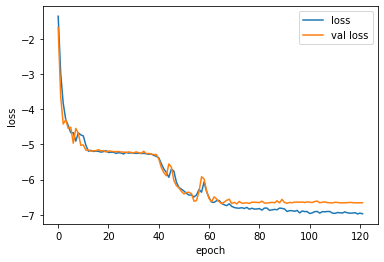

In [8]:
if mode == 'train':
    plt.figure(2111)
    plt.plot(history_best['loss'], label = 'loss')
    plt.plot(history_best['val_loss'], label = 'val loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

**Generating images from baseline to the original image**

In [10]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

baseline = tf.zeros(shape=(128,128,1))
m_steps=10
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

interpolated_images = interpolate_images(
    baseline=baseline,
    image=swe_test_data[0,],
    alphas=alphas)

**Plotting the interpolated images**

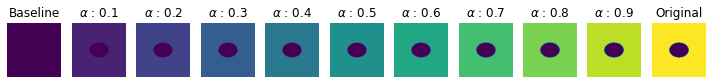

In [12]:
os.chdir('./Results_2/')

dirOut0 = '../output/python/deephyper/'+dtype+'/'
dirOut1 = 'plots_ae_'+dtype+'/N'+str(num_tot)+'/' 
Current_Model_directory = dirOut0 + dirOut1

fig = plt.figure(figsize=(10, 10))

i = 0
for alpha, image in zip(alphas[0:len(alphas)], interpolated_images[0:len(alphas)]):
  i += 1
  plt.subplot(1, len(alphas[0:len(alphas)]), i)
  if alpha != 0. and alpha != 1.:
      plt.title(r'$\alpha$ : '+f'{alpha:.1f}')
  elif alpha == 0.:
      plt.title('Baseline')
  else:
      plt.title('Original')
  plt.imshow(image,vmin=0,vmax=1)
  plt.axis('off')
plt.tight_layout()
plt.savefig(Current_Model_directory+'interpolated_inputs_60.png',format = 'png',dpi=500,bbox_inches='tight')

**Defining functions for the integrated gradient calculation**

Some of the functions below are taken from [this](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients) tensorflow tutorial.

In [13]:
trained_encoder = Model(model_best.input, model_best.layers[-2].output)
def compute_gradients(images, target_class_idx):
  images = tf.convert_to_tensor(images)
  with tf.GradientTape() as tape:
    tape.watch(tf.convert_to_tensor(images))
    logits = trained_encoder(tf.convert_to_tensor(images))
    probs = logits[:,target_class_idx]#tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]
    
    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)

  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

**Calculating integrated gradients for the first test sample (for demonstration)**

In [15]:
int_grad_list = []
for i in range(256):
    path_gradients = integrated_gradients(baseline=baseline,
        image=swe_test_data[0,],
        target_class_idx=i,m_steps=m_steps,batch_size=m_steps)
    int_grad_list.append(path_gradients)

**Save the integrated gradients (optional)**

In [16]:
import pickle
import os

os.chdir('./Results_2/')

dirOut0 = '../output/python/deephyper/'+dtype+'/'
dirOut1 = 'plots_ae_'+dtype+'/N'+str(num_tot)+'/' 
Current_Model_directory = dirOut0 + dirOut1

os.chdir(Current_Model_directory)
file_name = 'VIB_int_grad_0.pkl'
with open(file_name,'wb') as file:
    pickle.dump(int_grad_list,file)


**Plotting the integrated gradients**

In [18]:
import pickle
import os

def normalize(tensor,min_val,max_val):
  """Normalizes a tensor between 0 and 1.

  Args:
    tensor: The tensor to normalize.

  Returns:
    The normalized tensor.
  """

  return (tensor - min_val) / (max_val - min_val)

os.chdir('./Results_2/')
dirOut0 = '../output/python/deephyper/'+dtype+'/'
dirOut1 = 'plots_ae_'+dtype+'/N'+str(num_tot)+'/' 
Current_Model_directory = dirOut0 + dirOut1

os.chdir(Current_Model_directory)
from matplotlib import gridspec
nrow = 1
ncol = 10
fig = plt.figure(figsize=(ncol+1, nrow+1))
gs = gridspec.GridSpec(nrow, ncol,
                wspace=0, hspace=0, 
                top=1.-0.4/(nrow+1), bottom=0.0001/(nrow+1), 
                left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

for samp_i,samp_v in enumerate([0]):
    file_name = f"VIB_int_grad_{samp_v}.pkl"
    with open(file_name,'rb') as file:
        VIB_int_grad = pickle.load(file)

    VIB_hist_data = np.zeros([256*128*128])
    mv = 128*128
    for i in range(256):
        VIB_hist_data[i*mv:(i+1)*mv] = np.abs(tf.reshape(VIB_int_grad[i],[-1]).numpy())

    var1 = []
    VIB_int_grad_norm = []
    for i in range(256):
        VIB_int_grad_norm.append(normalize(tf.math.abs(VIB_int_grad[i]),np.min(np.abs(VIB_hist_data)),np.max(np.abs(VIB_hist_data))))
        var1.append(tf.math.reduce_sum(tf.cast(VIB_int_grad_norm[i]>0.4,tf.float32)))

    tmp = tf.convert_to_tensor(var1)

    id_tmp_VIB = tf.argsort(tmp,direction='DESCENDING').numpy()[:10]
    
    for k, val in enumerate(id_tmp_VIB):
                axes = plt.subplot(gs[samp_i,k])
                axes.set_xticks([])
                axes.set_yticks([])
                #axes.axis('off')
                tmp = tf.math.abs(VIB_int_grad_norm[val])
                pcm = axes.imshow(tmp, vmax=1, vmin=0, cmap='Reds')
                axes.set_xlabel(f"active: {int(var1[val])}")


plt.savefig("Pixel_importance_VIB.png",format = 'png',dpi=500,bbox_inches='tight')